# __KerasTuner para la construccion del mejor modelo__

### Cargar datos

In [1]:
# librerias
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import string
import tensorflow as tf

from tensorflow.keras import regularizers

# libreria para trabajar con las bases de datos 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-11-07 11:32:26.260368: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-07 11:32:26.489216: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-07 11:32:26.705145: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730997146.899668   24061 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730997146.955128   24061 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 11:32:27.329411: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Found 27455 images belonging to 24 classes.
Found 1425 images belonging to 24 classes.
Found 7172 images belonging to 24 classes.


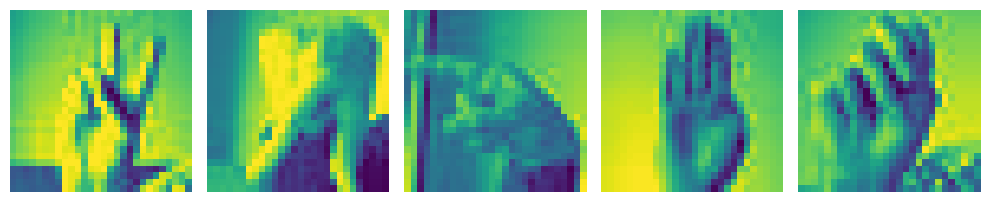

In [2]:
# ruta de los archivos
train_dir = './sign-language-img/Train'
test_dir = './sign-language-img/Test'

# data generator
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2)

# generator para test, training y validation
# para datos de entrenamiento
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (28, 28),
    batch_size = 128,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'training'
)

# para daros de validacion
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (28, 28),
    batch_size = 128,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'validation'
)

# para daros de prueba
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (28, 28),
    batch_size = 128,
    class_mode = 'categorical',
    color_mode = 'grayscale'
)

# clases
classes = [char for char in string.ascii_uppercase if char != 'J' if char != 'Z']

# funcion para mostrar las imagenes
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize = (10, 10))
    axes = axes.flatten()

    for img, ax in zip(images_arr, axes):
        ax.imshow(img[:,:,0])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# mostrar 5 imagenes
sample_training_images, _ = next(train_generator)
plotImages(sample_training_images[:5])

### Modelo a trabajar

El modelo con el que vamos a trabajar es el mismo con el que hemos venido trabajando. Vamos a definirlo

In [3]:
# funcion para generalizar la creacion del modelo
def get_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(75, (3,3), activation='relu'),
        tf.keras.layers.MaxPool2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, kernel_regularizer = regularizers.l2(1e-5), activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, kernel_regularizer = regularizers.l2(1e-5), activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(len(classes), activation='softmax')
    ])
    return model

### Implementando Autotuner

Vamos a cargar la libreria kerastuner y keras

In [4]:
import kerastuner as kt
from tensorflow import keras

/tmp/ipykernel_24061/2517507747.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


Para esta ocasión crearemos un nuevo constructor de modelos, este recibirá como parámetros un objeto tuner que determinará las variaciones de diferentes hiperparámetros.

- Arquitectura general, donde agregaremos una capa de convolución, Max Pooling y aplanamiento de manera fija

- Primer variable del constructor: La cantidad de neuronas en la siguiente capa oculta, se inicializará en 16 e incrementará hasta 32 dando saltos de 8 en 8.

- La capa oculta sera de 32 neuronas.

- La cantidad de neuronas de la siguiente capa será el objeto iterador. El resto de la red se mantendrá estable.

- Variaciones en el learning rate, donde empezaremos el modelo con 3 posibles learning rate: 0.01, 0.001 y 0.0001.

- Al momento de compilar el modelo definiremos Adam como optimizador, sin embargo, llamaremos directamente a la clase y le entregaremos el objeto iterador. El resto de parámetros seguirán iguales.

In [5]:
def constructor_modelos(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(75, (3,3), activation='relu', input_shape = (28,28,1)))
    model.add(tf.keras.layers.MaxPool2D((2,2)))
    model.add(tf.keras.layers.Flatten())

    hp_units = hp.Int('units', min_value=8, max_value=32, step=8)
    model.add(tf.keras.layers.Dense(units=hp_units, activation='relu', kernel_regularizer=regularizers.l2(1e-5)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-5)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(len(classes), activation='softmax'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(
        learning_rate=hp_learning_rate), 
        loss='categorical_crossentropy', 
        metrics=['accuracy'])
    return model

Esta función será la materia prima del tuner, el cual hará pruebas con todas las combinatorias para encontrar el modelo más optimo.

### Buscando la mejor configuracion para tu modelo

Con el generador de modelos definido podremos crear el tuner que iterará a través de la configuración expuesta.

Crearemos una instancia Hyperband (que será el objeto que iterará en las configuraciones). Sus parametros seran:

- Función generador
- Métrica objetivo (en este caso será val_accuracy para medir la precisión real del modelo)
- Máximo de 5 épocas
- factor de 2
- directorio de carga
- nombre de proyecto.

In [6]:
tuner = kt.Hyperband(
    constructor_modelos,
    objective = 'val_accuracy',
    max_epochs = 5,
    factor = 2,
    directory = './',
    project_name = 'tuner_project'
)

2024-11-07 11:32:42.443025: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Reloading Tuner from ./tuner_project/tuner0.json


Con en tuner generado, podremos empezar nuestra búsqueda. Entregamos al método:
- el dataset
- las épocas máximas
- los datos de validación

Empezamos el entrenamiento y esperamos a que se complete. Guardaremos el mejor desempeño en la variable best_hps

In [7]:
tuner.search(
    train_generator, 
    epochs=10, 
    validation_data= validation_generator
    )

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Para obtener las mejores configuraciones haremos uso del método get

In [8]:
# numero de neuronas optimas
print(best_hps.get('units'))

24


In [9]:
# tasa de aprendizaje optimo
print(best_hps.get('learning_rate'))

0.01


> El mejor modelo posee 24 neuronas y una taza de aprendizaje de 0.01

### Creando un modelo a partir de la mejor configuracion

Con los mejores hiperparámetros encontrados podremos construir un modelo optimizado, esto lo haremos con el método hypermodel.build de tuner que recibirá la configuración como argumento.

Ahora tenemos un modelo listo para ser entrenado, agregaremos el callback de early stopping para evitar sobre entrenamientos innecesarios.

In [10]:
callback_early = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=3,
    mode='auto'
)

In [11]:
hypermodel = tuner.hypermodel.build(best_hps)

history_hypermodel = hypermodel.fit(
    train_generator,
    epochs = 20,
    callbacks = [callback_early],
    validation_data = validation_generator
)

/home/jbernal/anaconda3/envs/tf_cpu/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/jbernal/anaconda3/envs/tf_cpu/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 49s 215ms/step - accuracy: 0.0450 - loss: 3.2176 - val_accuracy: 0.0288 - val_loss: 3.1967
Epoch 2/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 34s 157ms/step - accuracy: 0.0432 - loss: 3.1777 - val_accuracy: 0.0225 - val_loss: 3.2050
Epoch 3/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 32s 148ms/step - accuracy: 0.0464 - loss: 3.1772 - val_accuracy: 0.0196 - val_loss: 3.2009
Epoch 4/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 37s 171ms/step - accuracy: 0.0469 - loss: 3.1767 - val_accuracy: 0.0196 - val_loss: 3.2008
Epoch 5/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 39s 180ms/step - accuracy: 0.0473 - loss: 3.1772 - val_accuracy: 0.0196 - val_loss: 3.1987
Epoch 6/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 34s 157ms/step - accuracy: 0.0453 - loss: 3.1768 - val_accuracy: 0.0196 - val_loss: 3.2046
Epoch 7/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 35s 163ms/step - accuracy: 0.0445 - loss: 3.1767 - val_accuracy: 0.0288 - val_loss: 3.1978
Epoch 8/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 35s 163ms/step - accuracy: 0.0464 - loss: 3

> El early sttoping detecto que no estaba mejorando el modelo en cada epoca por lo que detuvo el entrenamiento en la epoca 12.

> El modelo alcanza un valor 0.0424 en accuracy de entrenamiento



# __Almacenamiento y carga del Modelo__

### Cargando y descargando arquitecturas sin pesos

Puedes usar la arquitectura de un modelo para basarte a la hora de entrenar otros modelos, esto no traerá los pesos, por lo que no será útil para realizar predicciones

Con el método get_config de tus modelos puedes adquirir un JSON completo con la información de la arquitectura de tu red.

In [13]:
config_dict = hypermodel.get_config()
print(config_dict)

{'name': 'sequential', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 28, 28, 1), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'filters': 75, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name

Para cargar un modelo con base en esta configuración bastará con usar el método from_config de los modelos secuenciales de Keras enviando como parámetro el JSON de configuración.

In [14]:
model_same_config = tf.keras.Sequential.from_config(config_dict)

Para verificar que sea la arquitectura del mismo modelo, vemos el summary

In [15]:
model_same_config.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 75)     │           750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 75)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12675)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │       304,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │           792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 306,566 (1.17 MB)

 Trainable params: 306,566 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

### Descargando arquitecturas con pesos

Para guardar arquitecturas con pesos es necesario usar el callback de ModelCheckpoint que nos permitirá guardar en disco el modelo con sus pesos.

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint

Creamos un modelo vacio que guardaremos despues

In [32]:
model_weight = get_model()
# summary para verificar el modelo que acabamos de crear
model_weight.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [33]:
model_weight.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

Crearemos la configuración para nuestro callback. Definimos el path donde se guardará el modelo, cada cuando se guardará, si solo guardará los pesos y el output de texto a recibir.

In [34]:
checkpoint_path = './model_checkpoint/checkpoint.weights.h5'

checkpoint_weight = ModelCheckpoint(
    filepath = checkpoint_path,
    save_freq = 'epoch',
    save_weights_only = True,
    verbose = 1
)

Entrenaremos el modelo sin olvidar agregar el callback.

In [35]:
history_weight = model_weight.fit(
    train_generator,
    epochs = 20,
    callbacks = [checkpoint_weight],
    validation_data = validation_generator
)

Epoch 1/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.2776 - loss: 2.4437
Epoch 1: saving model to ./model_checkpoint/checkpoint.weights.h5
215/215 ━━━━━━━━━━━━━━━━━━━━ 101s 443ms/step - accuracy: 0.2786 - loss: 2.4400 - val_accuracy: 0.7495 - val_loss: 0.7743
Epoch 2/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.8549 - loss: 0.4696
Epoch 2: saving model to ./model_checkpoint/checkpoint.weights.h5
215/215 ━━━━━━━━━━━━━━━━━━━━ 66s 305ms/step - accuracy: 0.8550 - loss: 0.4691 - val_accuracy: 0.8070 - val_loss: 0.6024
Epoch 3/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9617 - loss: 0.1596
Epoch 3: saving model to ./model_checkpoint/checkpoint.weights.h5
215/215 ━━━━━━━━━━━━━━━━━━━━ 64s 295ms/step - accuracy: 0.9618 - loss: 0.1595 - val_accuracy: 0.8302 - val_loss: 0.5475
Epoch 4/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9841 - loss: 0.0873
Epoch 4: saving model to ./model_checkpoint/checkpoint.weights.h5
215/215 ━━━━━━━━━━━━━━━

Con esto hemos guardado un historial entero de nuestro modelo, puedes revisarlo en el directorio model_checkpoints/checkpoint.weights.h5

Si deseas guardar manualmente los pesos de tu red lo puedes haces con el método save indicando el directorio de salida. Esta manera únicamente guardará la última iteración, por lo que si por alguna razón la red sufrió un daño en esta etapa, no podrás revertirlo (a comparación del callback que guarda el historial entero).

In [39]:
model_weight.save('./model_manual/my_model.keras')